In [2]:
%autoreload 2
%matplotlib inline

In [20]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import wcs
from astropy.coordinates import SkyCoord

In [75]:
from scipy.interpolate import Rbf

# Initialize data directory

In [5]:
path = "../../Data/Subaru_data/"

# Dust data

```
!open $path
```

In [6]:
dust = fits.open(path + "p358Dust.fits")

In [7]:
w = wcs.WCS(dust[0].header)

In [8]:
dust[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                   82                                                  
NAXIS2  =                   82                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'mag E(B-V)'                                                          
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =           273.000000                                                  
CRVAL2  =            40.0000

In [9]:
pix_coords = np.array([[i, j] for i in range(dust[0].data.shape[0])
              for j in range(dust[0].data.shape[1])])

In [10]:
wcs_coords = w.wcs_pix2world(pix_coords, 1)

In [50]:
wcs_x = np.array(wcs_coords.transpose()[0])
wcs_y = np.array(wcs_coords.transpose()[1])

In [12]:
dust[0].data.shape

(82, 82)

In [13]:
wcs_x_grid = wcs_x.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))
wcs_y_grid = wcs_y.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))

# basic dust properties

In [14]:
np.mean(dust[0].data.ravel())

0.036121546490218627

In [15]:
np.std(dust[0].data.ravel())

0.0085454334243817032

## convert pixel to WCS so we can apply correction to data catalog

<matplotlib.colorbar.Colorbar instance at 0x116c43950>

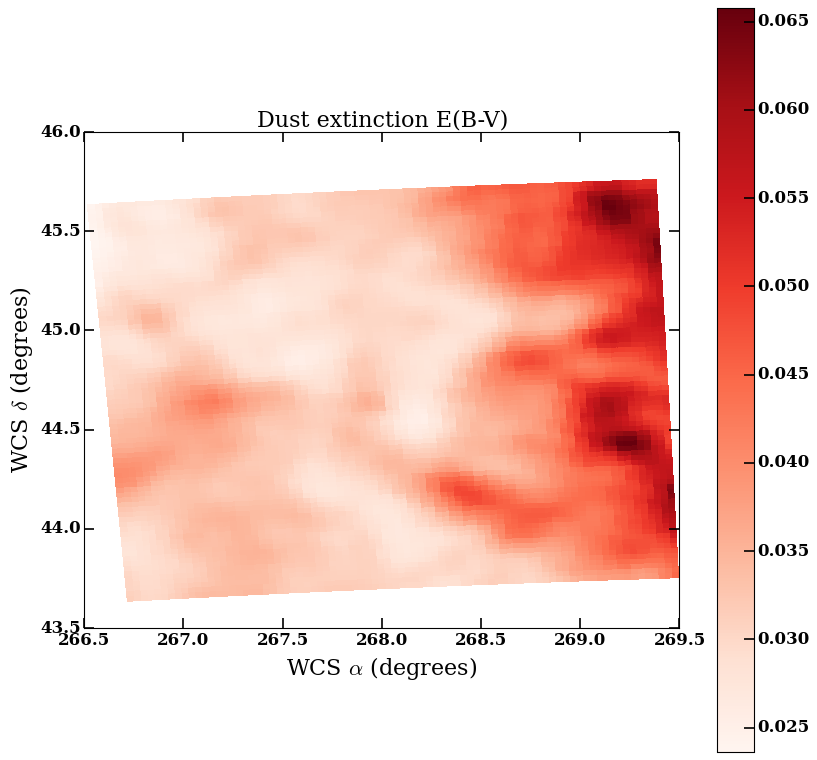

In [16]:
plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()



* checked the features of the above image with DS9
* ready to do dust extinction correction

\begin{equation}
E(B-V) \equiv A_B - A_V = (B-V)_{observed} - (B-V)_{intrinsic}
\end{equation}

Therefore, to correct for dust extinction in the (B-V) band, we have ...

\begin{equation}
(B-V)_{intrinsic} = (B - V)_{observed} - E(B-V)
\end{equation}

for each WCS pixel ... easy enough!
Reference: http://en.wikipedia.org/wiki/Extinction_(astronomy)

### examine how the dust map compared to the coordinates in the shape catalog

In [17]:
Rshapes = pd.read_hdf("../../Data/Subaru_data/Rshape_processed.h5", "df")

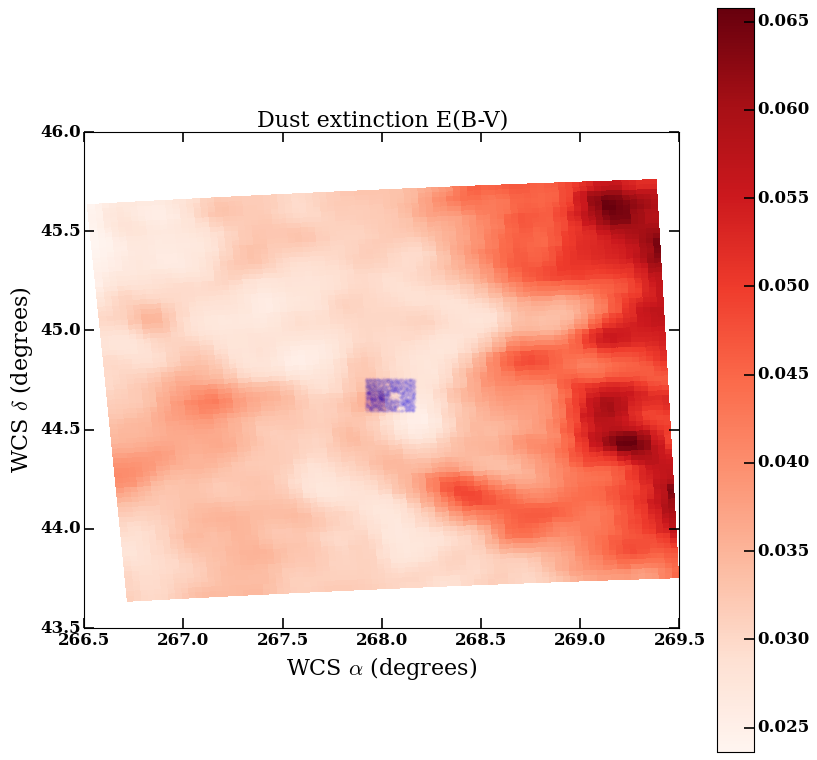

In [18]:

plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()

plt.plot(Rshapes.RA, Rshapes.DEC, '.', alpha=0.01)

# do interpolation

so our transformed dust data is actually diagonal so there are no longer just 81 x 81 grid in wcs coordinates... it's better for us to switch every thing to pixel coordinates then do interpolation

In [60]:
Rshapes_pix_coords = \
    w.wcs_world2pix(np.array([Rshapes.RA, Rshapes.DEC]).transpose(), 1)

In [89]:
XX, YY = np.meshgrid(range(dust[0].data.shape[0]),
                     range(dust[0].data.shape[0]))

In [95]:
rbf = Rbf(XX, YY, dust[0].data, epsilon=2)

In [96]:
dust_ext = rbf(list(Rshapes_pix_coords.transpose()[0]),
               list(Rshapes_pix_coords.transpose()[1]))

In [97]:
dust_ext.shape

(5355,)

In [98]:
dust_ext

array([ 0.02657549,  0.02972598,  0.03204378, ...,  0.02939387,
        0.0309722 ,  0.02983728])

<matplotlib.colorbar.Colorbar instance at 0x13b6b7320>

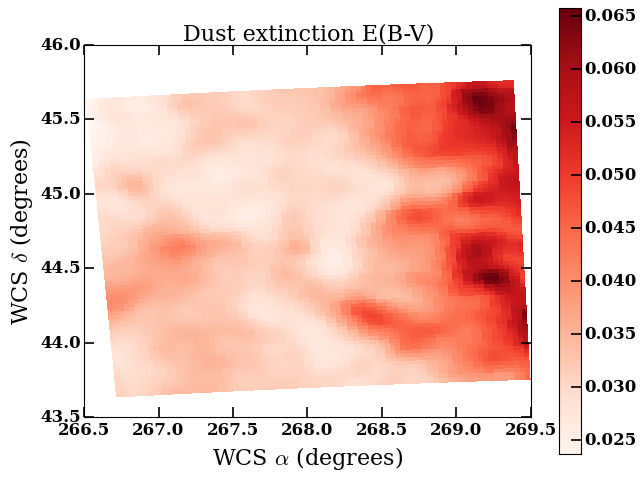

In [111]:
plt.axes().set_aspect("equal")


plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)

plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()

In [148]:
Rshapes["E(B-V)"] = dust_ext

In [149]:
Rshapes.to_hdf("../../Data/Subaru_data/Rshape_processed.h5", "df")

# stop being lazy and just cut out relevant region

# verifying that I did the interpolation correctly

recalculate where to cut ... ref: van Weeren 2012 Fig. 1

In [ ]:
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")
ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

In [ ]:
ra_mask = np.logical_and(wcs_x < ra_upper + 0.1,
                         wcs_x > ra_lower - 0.1)
dec_mask = np.logical_and(wcs_y < dec_upper + 0.1,
                          wcs_y > dec_lower - 0.1)
mask = np.logical_and(ra_mask, dec_mask)

In [ ]:
ix = np.arange(len(wcs_x))[mask]

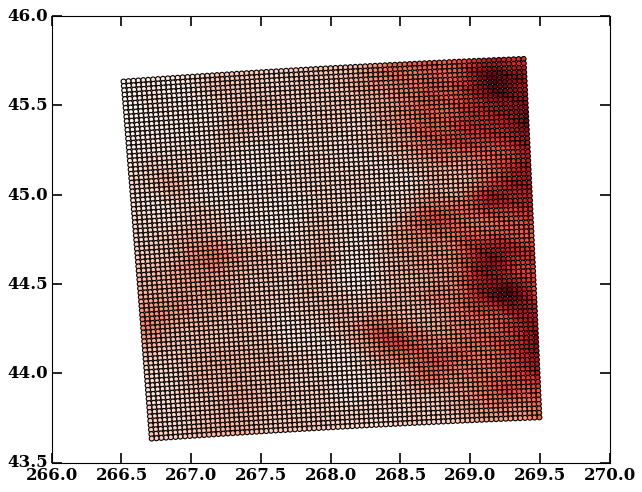

In [150]:
plt.scatter(wcs_x, wcs_y, c=dust[0].data.transpose().ravel(),
            cmap=plt.cm.Reds)

In [ ]:
plt.scatter(Rshapes.RA, Rshapes.DEC, c=dust_ext,
            cmap=plt.cm.Reds)
plt.scatter(wcs_x[ix], wcs_y[ix], c=dust[0].data.transpose().ravel()[ix],
            cmap=plt.cm.Reds)
plt.colorbar()